<a href="https://colab.research.google.com/github/Justsecret123/One-Piece-Image-Classifier/blob/master/Model_with_Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import PIL
import IPython

import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from keras.models import Sequential

import pathlib 
import zipfile

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 5.8MB/s 


# Files

## Dataset download

In [ ]:
data_path = 'drive/My Drive/Data.zip'
zip_ref = zipfile.ZipFile(data_path,'r')
zip_ref.extractall('/tmp/')

In [ ]:
data_dir = pathlib.PosixPath('/tmp/Data')

## Images count

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png'))) + len(list(data_dir.glob('*/*.jpeg'))) 
print(image_count)

2048


# Display some images

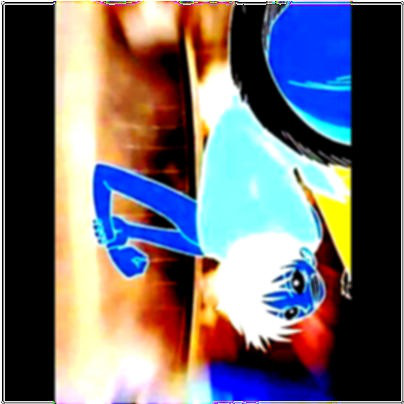

In [ ]:
Luffy = list(data_dir.glob('Luffy/*'))
PIL.Image.open(str(Luffy[0]))

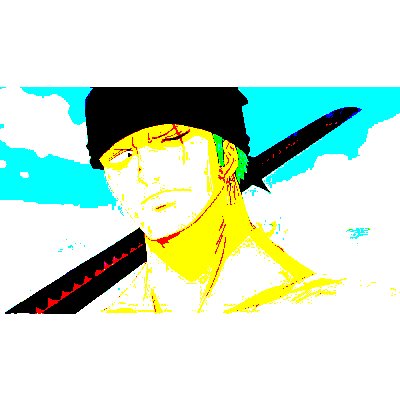

In [ ]:
Zoro = list(data_dir.glob('Zoro/*'))
PIL.Image.open(str(Zoro[0]))

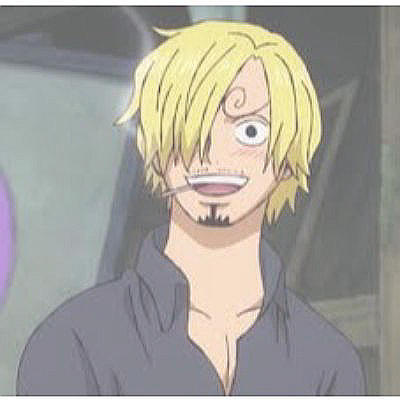

In [ ]:
Sanji = list(data_dir.glob('Sanji/*'))
PIL.Image.open(str(Sanji[0]))

# Model builder

## Some parameters 

In [ ]:
import random

In [ ]:
random.seed()
seed = random.randint(0,100)

In [ ]:
batch_size = 5
width = 180
height = 180

## Training dataset definition

In [ ]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(height,width),
    batch_size=batch_size
)

Found 2048 files belonging to 3 classes.
Using 1639 files for training.


In [ ]:
classes_count = 3
class_names = train_dataset.class_names
print(class_names)

['Luffy', 'Sanji', 'Zoro']


## Validation dataset definition

In [ ]:
val_dataset = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(height, width),
    batch_size=batch_size
)

Found 2048 files belonging to 3 classes.
Using 409 files for validation.


# Data augmentation

In [ ]:
data_augmentation = Sequential([
                                tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(height,width,3)),
                                tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                tf.keras.layers.experimental.preprocessing.RandomZoom(0.2), 
                    ])

# Model builder

## Description

*   3 Convolutional layers followed by a batch normalization layer, then a MaxPooling layer followed by a batch normalization layer  
*   A flatten layer 
*   A dense layer which number of units will be decided by the hyper parameters
*   A dropout layer (to reduce the overfitting problem)
*   And a dense layer which represents the final output 



*Note: when making predictions, we will apply a sigmoid to the return array to obtain the probability of the image belonging to each class*





In [ ]:
def model_builder(hp):
  
   hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
   hp_learning_rate = hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])

   model = tf.keras.models.Sequential()

   model.add(layers.Conv2D( filters=15, kernel_size=3, activation='relu'))
   model.add(layers.BatchNormalization()) 
   model.add(layers.MaxPool2D())
   model.add(layers.BatchNormalization())
   model.add(layers.Conv2D( filters=30, kernel_size=3, activation='relu'))
   model.add(layers.MaxPool2D())
   model.add(layers.BatchNormalization())
   model.add(layers.Conv2D( filters=60, kernel_size=3, activation='relu'))
   model.add(layers.MaxPool2D())
   model.add(layers.BatchNormalization())
   model.add(layers.Flatten())
   model.add(layers.Dense( units=hp_units, activation='relu', kernel_regularizer=keras.regularizers.L2(l2=0.001)))
   model.add(layers.BatchNormalization())
   model.add(layers.Dropout(0.5))
   model.add(layers.Dense( classes_count, activation='softmax' ))

   model.compile(
       optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
       loss='sparse_categorical_crossentropy', 
       metrics=['accuracy']
  )
   
   return model

# Hypertuning 

## Callback function : *early stopping*

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

## Tuner

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3
)

In [ ]:
tuner.search(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[stop_early]
)

Trial 30 Complete [00h 01m 18s]
val_accuracy: 0.7750611305236816

Best val_accuracy So Far: 0.8655256628990173
Total elapsed time: 00h 17m 54s
INFO:tensorflow:Oracle triggered exit


## Get the optimal parameters

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Model fit

In [ ]:
model = tuner.hypermodel.build(best_hps)

### Use early stopping to stop the training process if the validation accuracy stops increasing after 4 epochs, and restore the weights which minimize the validation accuracy

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode ="max", verbose=2, restore_best_weights=True)

In [ ]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    verbose=1, 
    callbacks = [stop_early]
)

Epoch 1/20
328/328 [==============================] - 9s 23ms/step - loss: 1.3548 - accuracy: 0.5387 - val_loss: 0.8039 - val_accuracy: 0.6528
Epoch 2/20
328/328 [==============================] - 6s 19ms/step - loss: 0.9437 - accuracy: 0.6449 - val_loss: 0.6474 - val_accuracy: 0.7213
Epoch 3/20
328/328 [==============================] - 7s 21ms/step - loss: 0.7849 - accuracy: 0.7114 - val_loss: 0.6027 - val_accuracy: 0.7653
Epoch 4/20
328/328 [==============================] - 6s 18ms/step - loss: 0.6083 - accuracy: 0.7834 - val_loss: 0.5537 - val_accuracy: 0.7848
Epoch 5/20
328/328 [==============================] - 6s 17ms/step - loss: 0.5843 - accuracy: 0.7761 - val_loss: 0.5451 - val_accuracy: 0.8020
Epoch 6/20
328/328 [==============================] - 6s 17ms/step - loss: 0.5308 - accuracy: 0.7968 - val_loss: 0.5394 - val_accuracy: 0.8020
Epoch 7/20
328/328 [==============================] - 6s 17ms/step - loss: 0.4424 - accuracy: 0.8322 - val_loss: 0.4512 - val_accuracy: 0.8484

# Model summary 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 178, 178, 15)      420       
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 178, 178, 15)      60        
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 89, 89, 15)        0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 89, 89, 15)        60        
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 87, 87, 30)        4080      
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 43, 43, 30)        0         
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 43, 43, 30)        1

# Predictions

In [ ]:
from google.colab import files
from keras.preprocessing import image

In [ ]:
class_names = train_dataset.class_names
class_names

['Luffy', 'Sanji', 'Zoro']

In [ ]:
def prediction(): 
  for filename in uploaded.keys():

    path = "/content/" + filename
    im = image.load_img(path,target_size=(180,180))
    
    inputs = image.img_to_array(im)

    inputs = np.vstack([inputs])

    inputs = tf.expand_dims(inputs,axis=0) #Creates a batch

    
    predictions = model.predict(inputs) #Make a prediction based on input values

    score = tf.nn.sigmoid(predictions[0]) #We use predictions[0] since predictions is a [[classes_count]] shape vector. 
                                          #(Could've used np.squeeze(predictions) instead)
    #Sigmoid will return the probability of the image belonging to each class.
    #Rather than a probability distribution, it is a set of probabilities.
    #Each label has its own probability, which do not depends on another label's probability.
    #Since we can have more than one character in the image, a sigmoid fits better than softmax which is a probability distribution. 
    #In our case, { P(X=Luffy) = score[0]
    #               P(X=Sanji) = score[1]
    #               P(X=Zoro) = score[2]
    #               P(X=Unknown) = score[3]
    #             } 

    print("Image: ", path)
    for i in range (len(score)):
      print("\nProbability of being " + class_names[i] + \
              ": ", 100*score[i].numpy() , "%")

    #print(predictions)

    object_score = np.max(score)  #np.argmax(score) :  returns the index with the highest score 
    object_class = class_names[np.argmax(score)]  #np.max(score) returns the highest probability of our input belonging to one of our classes
    

    plt.figure()
    plt.title("This image most likely belongs to " +str(object_class)+ \
              " category with a " + str(object_score) + " score.\n\n")
    
    plt.imshow(im)


    print("This image most likely belongs to " +str(object_class)+ \
          " category with a " + str(object_score) + " score. \n\n"
    )

In [ ]:
uploaded = files.upload() 

Saving Luffy, Zoro and Sanji.jpg to Luffy, Zoro and Sanji.jpg
Saving Luffy.jpg to Luffy.jpg
Saving Sanji.jpg to Sanji.jpg


Image:  /content/Luffy, Zoro and Sanji.jpg

Probability of being Luffy:  54.877281188964844 %

Probability of being Sanji:  60.395801067352295 %

Probability of being Zoro:  59.44282412528992 %
This image most likely belongs to Sanji category with a 0.603958 score. 


Image:  /content/Luffy.jpg

Probability of being Luffy:  72.88386821746826 %

Probability of being Sanji:  50.22611618041992 %

Probability of being Zoro:  50.05542039871216 %
This image most likely belongs to Luffy category with a 0.7288387 score. 


Image:  /content/Sanji.jpg

Probability of being Luffy:  50.00337362289429 %

Probability of being Sanji:  73.09313416481018 %

Probability of being Zoro:  50.012803077697754 %
This image most likely belongs to Sanji category with a 0.73093134 score. 




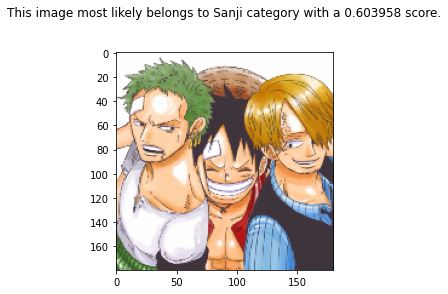

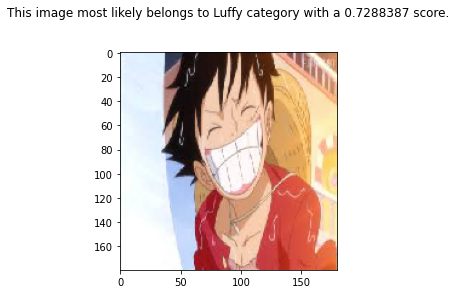

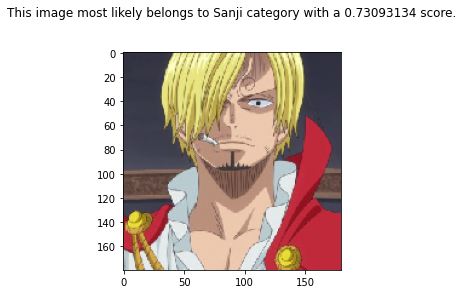

In [ ]:
prediction()

In [ ]:
model.save('drive/My Drive/Object_Detector_Model_KerasTuner_10epochs_Regularized_Early_Stopping')


INFO:tensorflow:Assets written to: drive/My Drive/Object_Detector_Model_KerasTuner_10epochs_Regularized_Early_Stopping/assets


INFO:tensorflow:Assets written to: drive/My Drive/Object_Detector_Model_KerasTuner_10epochs_Regularized_Early_Stopping/assets


In [ ]:
model.evaluate(x=val_dataset, return_dict=True)

82/82 [==============================] - 1s 10ms/step - loss: 0.3727 - accuracy: 0.8680


{'accuracy': 0.8679706454277039, 'loss': 0.3726581633090973}